In [1]:
import random
import torch
import torch_geometric

import torch.nn.functional as F
import sys
import os

from rdkit import Chem
from tqdm import tqdm
from copy import deepcopy

from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent

from pathlib import Path

cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
sys.path.append(parent_dir)

from torch_scatter import scatter_max, scatter_add

from DataPipeline.preprocessing import process_encode_graph, get_subgraph_with_terminal_nodes_step
from DataPipeline.preprocessing import node_encoder
from Model.GNN1 import ModelWithEdgeFeatures as GNN1
from Model.GNN1 import ModelWithNodeConcat as GNN1_node_concat
from Model.GNN2 import ModelWithEdgeFeatures as GNN2
from Model.GNN2 import ModelWithNodeConcat as GNN2_node_concat
from Model.GNN3 import ModelWithEdgeFeatures as GNN3
from Model.GNN3 import ModelWithgraph_embedding_modif as GNN3_embedding

In [2]:
def tensor_to_smiles(node_features, edge_index, edge_attr, edge_mapping = 'aromatic', encoding_type = 'charged'):
    # Create an empty editable molecule
    mol = Chem.RWMol()

    # Define atom mapping
    if encoding_type == 'charged':
        
        atom_mapping = {
            0: ('C', 0),
            1: ('N', 0),
            2: ('N', 1),
            3: ('N', -1),
            4: ('O', 0),
            5: ('O', -1),
            6: ('F', 0),
            7: ('S', 0),
            8: ('S', -1),
            9: ('Cl', 0),
            10: ('Br', 0),
            11: ('I', 0)
        }

    elif encoding_type == 'polymer':
        atom_mapping = {
            0: ('C', 0),
            1: ('N', 0),
            2: ('O', 0),
            3: ('F', 0),
            4: ('Si', 0),
            5: ('P', 0),
            6: ('S', 0)}

    # Add atoms
    for atom_feature in node_features:
        atom_idx = atom_feature[:12].argmax().item()
        atom_symbol, charge = atom_mapping.get(atom_idx)
        atom = Chem.Atom(atom_symbol)
        atom.SetFormalCharge(charge)
        mol.AddAtom(atom)

    # Define bond type mapping
    if edge_mapping == 'aromatic':
        bond_mapping = {
            0: Chem.rdchem.BondType.AROMATIC,
            1: Chem.rdchem.BondType.SINGLE,
            2: Chem.rdchem.BondType.DOUBLE,
            3: Chem.rdchem.BondType.TRIPLE,
        }
    elif edge_mapping == 'kekulized':
        bond_mapping = {
            0: Chem.rdchem.BondType.SINGLE,
            1: Chem.rdchem.BondType.DOUBLE,
            2: Chem.rdchem.BondType.TRIPLE,
        }

    # Add bonds
    for start, end, bond_attr in zip(edge_index[0], edge_index[1], edge_attr):
        bond_type_idx = bond_attr[:4].argmax().item()
        bond_type = bond_mapping.get(bond_type_idx)

        # RDKit ignores attempts to add a bond that already exists,
        # so we need to check if the bond exists before we add it
        if mol.GetBondBetweenAtoms(start.item(), end.item()) is None:
            mol.AddBond(start.item(), end.item(), bond_type)

    # Convert the molecule to SMILES
    smiles = Chem.MolToSmiles(mol)

    return smiles

def sample_random_subgraph_ZINC(pd_dataframe, start_size):
    indice = random.choice(pd_dataframe.index)
    smiles_str = pd_dataframe.loc[indice, 'smiles']

    torch_graph = process_encode_graph(smiles_str, encoding_option='reduced')
    subgraph_data, terminal_node_info, id_map = get_subgraph_with_terminal_nodes_step(torch_graph, start_size)

    return subgraph_data, terminal_node_info, id_map

import torch
from torch_geometric.data import Batch

def sample_first_atom_batch(batch_size, encoding = 'reduced'):
    if encoding == 'reduced' or encoding == 'charged':
        prob_dict = {'60': 0.7385023585929047, 
                    '80': 0.1000143018658728, 
                    '70': 0.12239949901813525, 
                    '90': 0.013786373862576426, 
                    '160': 0.017856330814654413,
                    '170': 0.007441135845856433}
    if encoding == 'polymer':
        prob_dict = {'60': 0.7489344573582472,
                    '70': 0.0561389266682314,
                    '80': 0.0678638375933265,
                    '160': 0.08724385192820308,
                    '90': 0.032130486119902095,
                    '140': 0.007666591133009364,
                    '150': 2.184919908044154e-05}

    atoms = [random.choices(list(prob_dict.keys()), weights=list(prob_dict.values()))[0] for _ in range(batch_size)]
    return atoms

def create_torch_graph_from_one_atom_list(atoms, edge_size, encoding_option='reduced') -> list:
    graphs = []
    for atom in atoms:
        num_atom = int(atom)
        atom_attribute = node_encoder(num_atom, encoding_option=encoding_option)
        # Create graph
        graph = torch_geometric.data.Data(x=atom_attribute.view(1, -1), edge_index=torch.empty((2, 0), dtype=torch.long), edge_attr=torch.empty((0, edge_size)))
        graphs.append(graph)

    
    return graphs


In [3]:
def return_current_nodes_batched(batch_graph, current_nodes_tensor : torch.tensor):

    # Count the number of nodes in each graph up to (but not including) the current node
    node_counts = batch_graph.batch.bincount().cumsum(0)
    offsets = torch.roll(node_counts, shifts=1, dims=0)
    offsets[0] = 0  # The first graph has no offset

    # Add the offsets to the current_nodes indices
    current_nodes_tensor += offsets

    return current_nodes_tensor
        

def set_feature_position(batch_graph, current_nodes_tensor):
    # Add feature position
    zeros_tensor = torch.zeros(batch_graph.x.size(0), 1, device=batch_graph.x.device)
    batch_graph.x = torch.cat([batch_graph.x, zeros_tensor], dim=1)
    current_nodes_expanded = current_nodes_tensor[batch_graph.batch]
    # Create a tensor that contains the cumulative sum of nodes up to the current node in each graph
    cumulative_current_nodes = (torch.arange(batch_graph.x.size(0), device=batch_graph.x.device) < (current_nodes_expanded)).float()
    # Flatten cumulative_current_nodes before using it for indexing
    cumulative_current_nodes = cumulative_current_nodes.view(-1)
    # Set the feature position for each node
    batch_graph.x[:, -1] = cumulative_current_nodes

    return batch_graph

def set_last_nodes(batch_graph):
    
    node_counts = batch_graph.batch.bincount().cumsum(0)
    offsets = torch.roll(node_counts, shifts=1, dims=0)
    offsets[0] = 0  # The first graph has no offset
    last_nodes_each_graph = batch_graph.batch.bincount() - 1 + offsets
    batch_graph.x[last_nodes_each_graph, -1] = 1

    return batch_graph, last_nodes_each_graph


def create_mask(batch_graph, current_nodes_tensor : torch.tensor, last_nodes):
    total_nodes = batch_graph.x.size(0)
    # Expand current_nodes to match the total number of nodes
    expanded_current_nodes = current_nodes_tensor[batch_graph.batch]
    mask = (torch.arange(batch_graph.x.size(0), device=batch_graph.x.device) > (expanded_current_nodes)).float()
    # Create a new mask where the last node of each graph is marked as False
    mask[last_nodes] = False

    # Convert the mask to a boolean mask
    mask = mask.bool()
    
    return mask


def add_nodes_and_edges(graphs, new_nodes, new_edges, current_nodes, mask_gnn2):
    # Iterate over the graphs, new nodes and edges, current nodes and mask simultaneously
    for graph, new_node, new_edge, current_node, add in zip(graphs, new_nodes, new_edges, current_nodes, mask_gnn2):
        # If the mask for this graph is False, do nothing
        if not add:
            continue
      
        # Add the new node to the graph
        graph.x = torch.cat([graph.x, new_node.unsqueeze(0)], dim=0)
        
        # Add an edge from the new node to the current node, and from the current node to the new node
        # to ensure that the graph remains undirected
        new_node_index = graph.x.size(0) - 1  # The index of the new node

        new_edge_indices = torch.tensor([[new_node_index, current_node], [current_node, new_node_index]], device=graph.edge_index.device)
        graph.edge_index = torch.cat([graph.edge_index, new_edge_indices], dim=1)
        
        # Add the new edge attributes to the graph
        graph.edge_attr = torch.cat([graph.edge_attr, new_edge.unsqueeze(0).repeat(2, 1)], dim=0)
    
    return graphs

def select_node_batch(tensor, batch_data, edge_size, mask):
    # Sum on the first dimensions of each vector
    sum_on_first_dims = tensor[:, :edge_size - 1].sum(dim=1)

    # Apply mask to the sum tensor, setting masked values to -inf
    masked_sum = sum_on_first_dims.masked_fill(~mask, float('-inf'))

    # Use scatter_max to find maximum values and their indices for each batch
    max_values, max_indices = scatter_max(masked_sum, batch_data, dim_size=batch_data.max().item() + 1)

    # Check if there is at least one True value in each graph
    count_mask = scatter_add(mask.int(), batch_data, dim_size=batch_data.max().item() + 1)

    # Replace indices where there were no True values in the mask with -1 (or any value you want)
    max_indices = max_indices.where(count_mask > 0, torch.tensor(-1).to(max_indices.device))

    # Sample using the tensor using the multinomial function
    sampled_indices = tensor.multinomial(num_samples=1).squeeze()

    # Replace -1 values in max_indices with the corresponding sampled_indices
    final_indices = torch.where(max_indices != -1, sampled_indices[max_indices], tensor.size(1) - 1)

    return final_indices, max_indices

# Function to check the valence of the nodes in the graph

def check_valence(graph, node):
    # Get the type of the node
    node_type = torch.argmax(graph.x[node])

    # Compute the valence of each node by summing the bond types of all edges connected to the node
    bond_types = torch.argmax(graph.edge_attr, dim=1) + 1  # add 1 to count single bonds as 1, etc.
    valences = torch.bincount(graph.edge_index[0], weights=bond_types)

    # Check if the valence is superior to the limit
    if node_type == 0:
        max_valence = 4
    elif node_type in [1, 2]:
        max_valence = 3
    else:
        max_valence = 6

    if valences[node].item() > max_valence:
        raise ValueError(f"Valence of node {node} is superior to {max_valence}")

    return valences
    
def add_edges_and_attributes(graphs, indices, choices, num_choices, batch, mask):
    # Create a one-hot encoded tensor of shape [num_choices, len(choices)]
    one_hot_choices = torch.zeros(num_choices, choices.size(0), device=choices.device).scatter_(0, choices.unsqueeze(0), 1)

    # Compute cumulative node counts for each graph
    node_counts = torch.bincount(batch)
    node_counts_shifted = torch.cat([torch.tensor([0], device=node_counts.device), node_counts[:-1]])
    cumulative_node_counts = node_counts_shifted.cumsum(0)

    # Compute indices in each graph
    indices_in_each_graph = indices - cumulative_node_counts[batch[indices]]

    for i, graph in enumerate(graphs):
        if mask[i]:
            # Add an edge from the max_index node to the last node
            last_node_index = graph.num_nodes - 1

            if choices[i] != num_choices - 1:  # If the choice is not the last column

                # Add the edge
                new_edge = torch.tensor([[indices_in_each_graph[i], last_node_index], [last_node_index, indices_in_each_graph[i]]], device=graph.edge_index.device)
                graph.edge_index = torch.cat([graph.edge_index, new_edge], dim=1) if graph.edge_index is not None else new_edge

                # Add the corresponding edge attribute
                new_attr = one_hot_choices[:, i].unsqueeze(1).t() 
                graph.edge_attr = torch.cat([graph.edge_attr, new_attr, new_attr], dim=0) if graph.edge_attr is not None else new_attr

    return graphs


In [4]:
def load_model(checkpoint_path, model, optimizer):

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer

def get_model_GNN1(config, encoding_size, edge_size):

    return GNN1(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                mlp_hidden_channels=config['mlp_hidden'],
                edge_channels=edge_size, 
                num_classes=encoding_size, 
                use_dropout=config['use_dropout'],
                size_info=config['use_size'],
                max_size=config['max_size'])

def get_model_GNN2(config, encoding_size, edge_size):

    return GNN2(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                mlp_hidden_channels=config['mlp_hidden'],
                edge_channels=edge_size, 
                num_classes=edge_size, 
                size_info=config['use_size'],
                max_size=config['max_size'],
                use_dropout=config['use_dropout'])

def get_model_GNN3(config, encoding_size, edge_size):

    if config['graph_embedding']:
        return GNN3_embedding(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                    hidden_channels_list=config["GCN_size"],
                    mlp_hidden_channels = config['mlp_hidden'],
                    edge_channels=edge_size, 
                    num_classes=edge_size,
                    use_dropout=config['use_dropout'],
                    size_info=config['use_size'],
                    max_size=config['max_size'])

    return GNN3(in_channels=encoding_size + int(config['feature_position'] + int(len(config['score_list']))),
                hidden_channels_list=config["GCN_size"],
                edge_channels=edge_size, 
                use_dropout=config['use_dropout'])

def get_optimizer(model, lr):
    return torch.optim.Adam(model.parameters(), lr=lr)


def add_score_features(subgraph, scores_list, desired_scores_list, GNN_type = 1):

    if scores_list != []:
        assert len(scores_list) == len(desired_scores_list) 
        # Concat the scores to the node features
        for i, score in enumerate(scores_list):
            score_tensor = torch.tensor(desired_scores_list[i], dtype=torch.float).view(1, 1)
            # Duplicate the score tensor to match the number of nodes in the subgraph
            score_tensor = score_tensor.repeat(subgraph.x.size(0), 1)
            subgraph.x = torch.cat([subgraph.x, score_tensor], dim=-1)
        if GNN_type == 2:
            subgraph.neighbor = torch.cat([subgraph.neighbor, torch.zeros((1, len(scores_list)))], dim=-1)
    return subgraph


class MolGenBatch():
    def __init__(self, GNN1, GNN2, GNN3, encoding_size, edge_size, batch_size, feature_position, device, save_intermidiate_states = False, encoding_option = 'charged', score_list = [], desired_score_list = []):

        self.mol_graphs_list = create_torch_graph_from_one_atom_list(sample_first_atom_batch(batch_size = batch_size, encoding = encoding_option), edge_size=edge_size, encoding_option=encoding_option)
        self.queues = [[0] for _ in range(batch_size)]
        self.batch_size = batch_size
        self.GNN1 = GNN1
        self.GNN2 = GNN2
        self.GNN3 = GNN3
        self.device = device
        self.feature_position = feature_position
        self.encoding_size = encoding_size
        self.edge_size = edge_size
        self.save_intermidiate_states = save_intermidiate_states
        if save_intermidiate_states:
            self.intermidiate_states = []

        self.score_list = score_list
        self.desired_score_list = desired_score_list
        self.finished_molecules = []

    def one_step(self):
        with torch.no_grad():

            # Lists to store the updated queues and current_nodes
            updated_queues = []
            current_nodes = []
            new_mol_graphs_list = []

            # Loop over each queue
            for i, queue in enumerate(self.queues):
                # If a queue is empty, its corresponding molecule is finished
                if not queue:
                    self.finished_molecules.append(self.mol_graphs_list[i])
                    self.batch_size -= 1
                else:
                    updated_queues.append(queue)
                    new_mol_graphs_list.append(self.mol_graphs_list[i])
                    current_nodes.append(queue[0])

            # Replace the original mol_graphs_list with the new one
            self.mol_graphs_list = new_mol_graphs_list
            self.queues = updated_queues

            if len(self.mol_graphs_list) == 0:
                return 
            """
            Prepare the GNN 1 BATCH
            """
            batch_graph12 = Batch.from_data_list(self.mol_graphs_list).to(self.device)
            current_nodes_tensor = torch.tensor(current_nodes, device=self.device, dtype=torch.long)
            current_nodes_batched = return_current_nodes_batched(batch_graph12, current_nodes_tensor) #reindex the nodes to match the batch size
            batch_graph12.x[current_nodes_batched, -1] = 1
            
            if self.feature_position:
                batch_graph12 = set_feature_position(batch_graph12, current_nodes_batched)
            
            batch_graph12 = add_score_features(batch_graph12, self.score_list, self.desired_score_list, GNN_type = 1)
            predictions = self.GNN1(batch_graph12)

            # Apply softmax to prediction
            softmax_predictions = F.softmax(predictions, dim=1)
            # Sample next node from prediction
            predicted_nodes = torch.multinomial(softmax_predictions, num_samples=1)

            # Create a mask for determining which graphs should continue to GNN2
            mask_gnn2 = (predicted_nodes != self.encoding_size - 1).flatten()

            # Handle the stopping condition (where predicted_node is encoding_size - 1)
            stop_mask = (predicted_nodes == self.encoding_size - 1).flatten()
            # Remove the first node from the queues of graphs that have stopped
            self.queues = [queue[1:] if stopped else queue for queue, stopped in zip(self.queues, stop_mask)]

            # Encode next node for the entire batch
            encoded_predicted_nodes = torch.zeros(predictions.size(), device=self.device, dtype=torch.float)
            encoded_predicted_nodes.scatter_(1, predicted_nodes, 1)

            # Add the size of x to the queue for graphs that haven't stopped
            self.queues = [queue + [graph.x.size(0)] if continue_gnn2 else queue
                        for queue, graph, continue_gnn2 in zip(self.queues, self.mol_graphs_list, mask_gnn2)]

            #GNN2 

            if self.feature_position:
                    
                # add zeros to the neighbor
                encoded_predicted_nodes = torch.cat([encoded_predicted_nodes, torch.zeros(self.batch_size, 1).to(encoded_predicted_nodes.device)], dim=1)

            batch_graph12.neighbor = encoded_predicted_nodes

            batch_graph12 = add_score_features(batch_graph12, self.score_list, self.desired_score_list, GNN_type = 2)

            assert batch_graph12.x.size(1) == batch_graph12.neighbor.size(1)
            
            predictions2 = self.GNN2(batch_graph12.to(self.device))
            predicted_edges = torch.multinomial(F.softmax(predictions2, dim=1), num_samples=1)

            encoded_predicted_edges = torch.zeros_like(predictions2, device=self.mol_graphs_list[0].x.device, dtype=torch.float)
            encoded_predicted_edges.scatter_(1, predicted_edges.detach().cpu(), 1)
            
            # Create a new node that is going to be added to the graph for each batch
            new_nodes = torch.zeros(self.batch_size, self.encoding_size, device=self.mol_graphs_list[0].x.device, dtype=torch.float)
            new_nodes.scatter_(1, predicted_nodes.detach().cpu(), 1)
            #GNN3

            # Add the node and the edge to the graph
            new_graph_list = add_nodes_and_edges(self.mol_graphs_list, new_nodes, encoded_predicted_edges, current_nodes, mask_gnn2)
            batch_graph3 = Batch.from_data_list(new_graph_list).to(self.device)
            batch_graph3, last_nodes = set_last_nodes(batch_graph3)
            current_nodes_batched = return_current_nodes_batched(batch_graph3, torch.tensor(current_nodes, device=self.device, dtype=torch.long)) #reindex the nodes to match the batch size
            
            if self.feature_position:
                batch_graph3 = set_feature_position(batch_graph3, current_nodes_batched)
            
            mask = create_mask(batch_graph3, current_nodes_tensor = current_nodes_batched, last_nodes = last_nodes)
            batch_graph3.mask = mask

            batch_graph3 = add_score_features(batch_graph3, self.score_list, self.desired_score_list, GNN_type = 3)

            prediction3 = self.GNN3(batch_graph3)
            
            softmax_prediction3 = F.softmax(prediction3, dim=1)
            edges_predicted, max_indices = select_node_batch(softmax_prediction3, batch_graph3.batch, self.edge_size, mask)
            new_graph_list = add_edges_and_attributes(new_graph_list, max_indices.detach().cpu(), edges_predicted.detach().cpu(), self.edge_size, batch_graph3.batch.detach().cpu(), mask_gnn2)


            self.mol_graphs_list = new_graph_list

    def full_generation(self):
        max_iter = 150
        i = 0
        while len(self.queues) > 0:
            if i > max_iter:
                break
            self.one_step()
            i += 1

            if self.save_intermidiate_states:
                self.intermidiate_states.append(self.mol_graph.clone())
        
    def is_valid(self):
        if self.edge_size == 3:
            edge_mapping = 'kekulized'
        else:
            edge_mapping = 'aromatic'
        SMILES_str = tensor_to_smiles(self.mol_graph.x, self.mol_graph.edge_index, self.mol_graph.edge_attr, edge_mapping, encoding_type=self.encoding_type)
        mol = Chem.MolFromSmiles(SMILES_str)
        if mol is None:
            return False
        else:
            return True


class GenerationModuleBatch():
    def __init__(self, config1, config2, config3, encoding_size, edge_size, pathGNN1, pathGNN2, pathGNN3, checking_mode = False, encoding_type = 'charged', batch_size = 64, score_list = [], desired_score_list = []):
        self.config1 = config1
        self.config2 = config2
        self.config3 = config3
        self.encoding_size = encoding_size
        self.edge_size = edge_size
        self.batch_size = batch_size
        self.encoding_type = encoding_type
        self.feature_position = config1["feature_position"]
        self.checking_mode = checking_mode

        self.score_list = config1["score_list"]
        self.desired_score_list = desired_score_list

        if self.checking_mode:
            self.non_valid_molecules = []

        self.GNN1 = get_model_GNN1(config1, encoding_size, edge_size)
        self.GNN2 = get_model_GNN2(config2, encoding_size, edge_size)
        self.GNN3 = get_model_GNN3(config3, encoding_size, edge_size)

        self.optimizer_GNN1 = torch.optim.Adam(self.GNN1.parameters(), lr=config1["lr"])
        self.optimizer_GNN2 = torch.optim.Adam(self.GNN2.parameters(), lr=config2["lr"])
        self.optimizer_GNN3 = torch.optim.Adam(self.GNN3.parameters(), lr=config3["lr"])

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.GNN1_model, self.optimizer_GNN1 = load_model(pathGNN1, self.GNN1, self.optimizer_GNN1)
        self.GNN2_model, self.optimizer_GNN2 = load_model(pathGNN2, self.GNN2, self.optimizer_GNN2)
        self.GNN3_model, self.optimizer_GNN3 = load_model(pathGNN3, self.GNN3, self.optimizer_GNN3)

        self.GNN1_model.to(self.device)
        self.GNN2_model.to(self.device)
        self.GNN3_model.to(self.device)

        self.GNN1_model.eval()
        self.GNN2_model.eval()
        self.GNN3_model.eval()
    
    def generate_single_molecule(self):
        mol = MolGen(self.GNN1_model,
                     self.GNN2_model,
                     self.GNN3_model,
                     self.encoding_size,
                     self.edge_size,
                     self.batch_size,
                     self.feature_position,
                     self.device,
                     save_intermidiate_states=self.checking_mode,
                     encoding_option=self.encoding_type,
                     score_list=self.score_list,
                     desired_score_list=self.desired_score_list)
        mol.full_generation()
        if self.checking_mode:
            # check validity of the molecule
            if not mol.is_valid():
                self.non_valid_molecules.append(mol.intermidiate_states)
        return mol.finished_molecules

    def generate_mol_list(self, n_mol, n_threads=1):
        mol_list = []
        if n_threads == 1:
            for i in tqdm(range(n_mol), desc="Generating molecules"):
                mol_graph = self.generate_single_molecule()
                mol_list += mol_graph
        else:

            # Utilize ThreadPoolExecutor to parallelize the task
            with ThreadPoolExecutor(max_workers=n_threads) as executor:
                # Submit tasks to the thread pool
                future_to_mol = {executor.submit(self.generate_single_molecule): i for i in range(n_mol)}
                
                # Collect the results as they become available
                for future in tqdm(as_completed(future_to_mol), total=n_mol, desc="Generating molecules"):
                    mol_graph = future.result()
                    mol_list.append(mol_graph)
                    
        return mol_list


In [5]:
# All paths 

GENERATED_SAVING_DIR = Path('..') / 'generated_mols' / 'raw'
SCORED_SAVING_DIR = Path('..') / 'generated_mols' / 'scored'
ZINC_DATA_PATH = SCORED_SAVING_DIR / 'scored_zinc.csv'

SAVE_RESULTS_PATH = Path('..') / 'generate_analyse_mols' / 'results'

In [6]:
def load_best_models(path):
    with open(path/'six_best_epochs.txt', 'r') as f:
        lines = f.readlines()
        epoch_values = [float(line.split(' ')[1]) for line in lines]
        best_line_index = epoch_values.index(max(epoch_values))
        loss_value = float(lines[best_line_index].split(' ')[-1])
    print('Loading best checkpoint number {} of the epoch {} with a loss of {}'.format(best_line_index, epoch_values[best_line_index], loss_value))
    checkpoint_path = path / 'history_training' / f'checkpoint_{best_line_index}.pt'
    return checkpoint_path

In [7]:
experiment_name = 'GNN_baseline'
experiment_path = Path('..') / 'trained_models' / experiment_name

In [8]:
import json

# List the folders in the experiment path

folders = os.listdir(experiment_path)
for folder in folders:
    if folder.startswith('GNN1'):
        GNN1_path = experiment_path / folder 
    elif folder.startswith('GNN2'):
        GNN2_path = experiment_path / folder
    elif folder.startswith('GNN3'):
        GNN3_path = experiment_path / folder

# Read the config as a json

config1_path = GNN1_path / 'parameters.json'
config2_path = GNN2_path / 'parameters.json'
config3_path = GNN3_path / 'parameters.json'

with open(config1_path, 'r') as f:
    config1 = json.load(f)
with open(config2_path, 'r') as f:
    config2 = json.load(f)
with open(config3_path, 'r') as f:
    config3 = json.load(f)

# Open the models with the best loss on the validation set


GNN1_path = load_best_models(GNN1_path)
GNN2_path = load_best_models(GNN2_path)
GNN3_path = load_best_models(GNN3_path)

print(GNN1_path, GNN2_path, GNN3_path)

encoding_size = 13


edge_size = 3


module = GenerationModule(config1=config1, 
                        config2=config2, 
                        config3=config3, 
                        encoding_size = encoding_size,
                        edge_size = edge_size, 
                        pathGNN1=GNN1_path, 
                        pathGNN2=GNN2_path, 
                        pathGNN3=GNN3_path,
                        encoding_type='charged',
                        batch_size = 3000,
                        desired_score_list=[])

print('Generating molecules...')
graph_batch = module.generate_mol_list(1)

Loading best checkpoint number 1 of the epoch 2050.0 with a loss of 0.5107812829972882
Loading best checkpoint number 1 of the epoch 2550.0 with a loss of 0.1984780294417413
Loading best checkpoint number 0 of the epoch 3000.0 with a loss of 0.05697827504829092
..\trained_models\GNN_baseline\GNN1_baseline\history_training\checkpoint_1.pt ..\trained_models\GNN_baseline\GNN2_baseline\history_training\checkpoint_1.pt ..\trained_models\GNN_baseline\GNN3_baseline\history_training\checkpoint_0.pt
Generating molecules...


Generating molecules: 100%|██████████| 1/1 [00:48<00:00, 48.45s/it]


In [9]:

from FinalPipeline.utils import GenerationModule, tensor_to_smiles
def convert_to_smiles(graph, kekulize=True, encoding_type='charged'):
    smiles = []
    for g in graph:
        smiles.append(tensor_to_smiles(g.x, g.edge_index, g.edge_attr, edge_mapping='kekulized', encoding_type=encoding_type))
    return smiles

In [10]:
smiles_list = convert_to_smiles(graph_batch, kekulize=True, encoding_type='charged')

In [11]:
smiles_list

['ClC1(Cl)CCCC1',
 'CN1C=C[NH+]=C1N',
 '[NH3+]C1C=CC(O)C1O',
 'CN1CC(=O)CC1=O',
 'CC1=CC([O-])=NC=C1',
 'CC1(C)CCS(=O)(=O)O1',
 'CC([NH3+])C1CC[NH2+]CC1',
 'CCCN1N=NN=C1CO',
 'C[NH2+]CC1=CC(C#N)=CS1',
 'CC([NH3+])CCC1CCSC1',
 'CCC(C)C1(O)CCOC1',
 'CCCSCC1CC1(Cl)Cl',
 'CN1CCC2CC1CC[NH2+]2',
 'COC(=O)NC1=NC=CS1',
 'CC(=O)C(C)SCCCS',
 'CC=CC1=CC=C(F)C=C1',
 'CC1=C(C)C=C2NN=CC2=C1',
 'CC(C)C([NH3+])C1CCC[NH2+]C1',
 'NC(=O)C[NH+]1CCCC(O)C1',
 'COC1=CC(=O)C(O)=CC1=O',
 'C=CC(=O)N1CCCCC1C',
 'CC1(C)CCCC(C[NH3+])C1O',
 'CCCC(C)(O)CC=[N+](C)C',
 'CC(C)(C)C1=CC=C(O)C=C1',
 'CC(C)C(O)C(O)C(O)CO',
 'CCN1CCC([NH3+])C(C)C1C',
 'CCOC(=O)C=C(C=O)CC',
 'CC(C)(C)[NH2+]CC1=CNC=C1',
 'CC(C)COC1CC[NH2+]CC1',
 'CCCC1=NC(C(=O)[O-])=NN1',
 'CC1=CC=CNC12CCCCC2',
 'CC1=CC=C(C2=NN=C(C)O2)S1',
 'NC1=NC2=NC=NC(=N1)C2=NS',
 'CC(C#N)N1C=NC([N+](=O)[O-])=C1',
 'COC(=O)C1=CC(C)=[NH+]C=C1[O-]',
 'OCC1=CSC(C2=CC=CO2)=N1',
 'C#CCC(O)(C(=O)[O-])C1(C)CC1',
 'CCCC1=CC=C2OCOC2=C1',
 '[NH3+]C(CN1CCCC1=O)C(=O)[O-]',
 '[O-][N+]

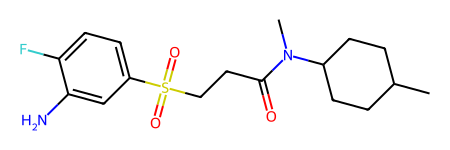

In [18]:
Chem.MolFromSmiles(smiles_list[2000])

In [13]:
def check_validity(smiles_list):
    from rdkit import Chem
    valid_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_smiles.append(smiles)
    return valid_smiles

In [19]:
# Get the non valid molecules

valid_smiles = check_validity(smiles_list)
non_valid_smiles = list(set(smiles_list) - set(valid_smiles))
len(valid_smiles)

3000

In [20]:
# Get the average number of atoms in the list 
import numpy as np
def get_average_number_atoms(smiles_list):
    from rdkit import Chem
    n_atoms = []
    max_atoms = 0
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        n_atoms.append(mol.GetNumAtoms())
        if mol.GetNumAtoms() > max_atoms:
            max_atoms = mol.GetNumAtoms()
    return np.mean(n_atoms), max_atoms

In [21]:
get_average_number_atoms(smiles_list)

(22.409333333333333, 41)

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw

def plot_molecules(df, num_mols=100):
    mols = [Chem.MolFromSmiles(smiles) for smiles in df.iloc[:,0].head(num_mols)]
    return Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), useSVG=True)


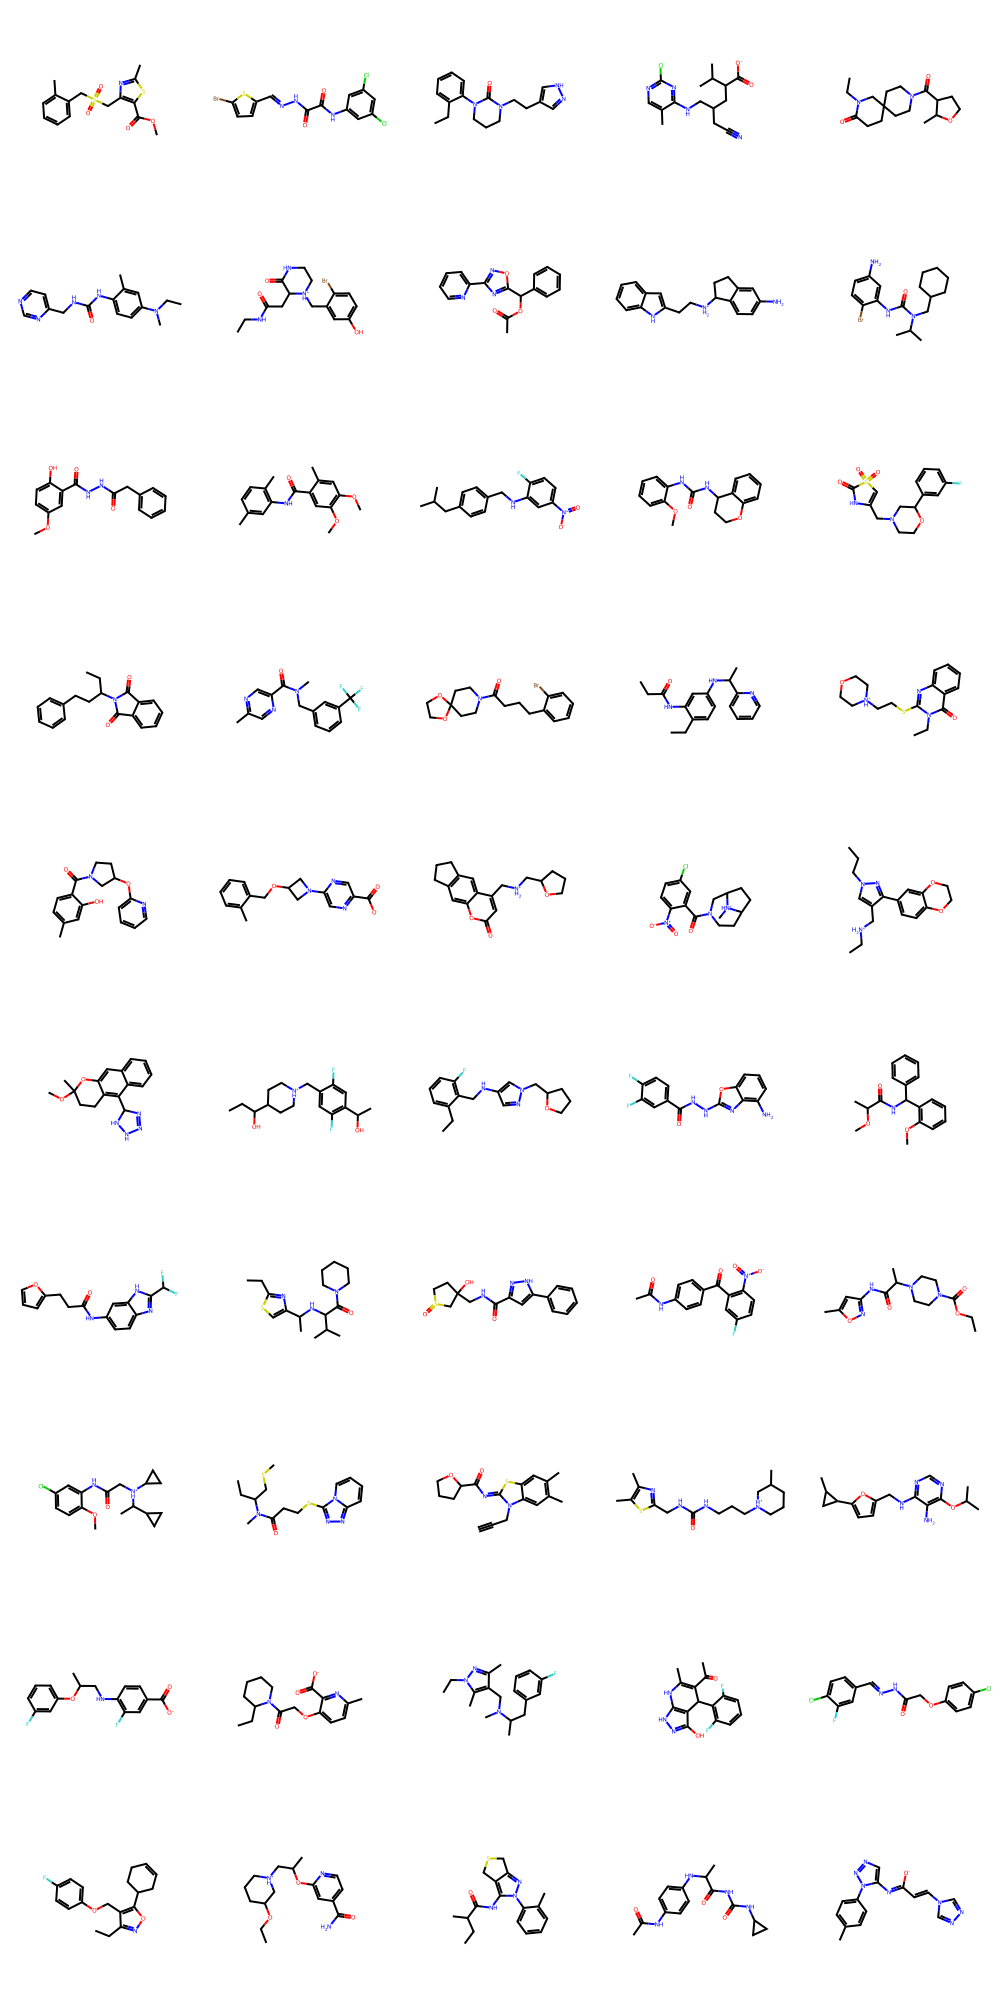

In [24]:
import pandas as pd
plot_molecules(pd.DataFrame(smiles_list[1500:]))